In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/segmentation-dataset/aug_data/aug_data/images/00484_2.jpg
/kaggle/input/segmentation-dataset/aug_data/aug_data/images/00541_4.jpg
/kaggle/input/segmentation-dataset/aug_data/aug_data/images/00305_0.jpg
/kaggle/input/segmentation-dataset/aug_data/aug_data/images/00052_2.jpg
/kaggle/input/segmentation-dataset/aug_data/aug_data/images/00218_2.jpg
/kaggle/input/segmentation-dataset/aug_data/aug_data/images/00353_0.jpg
/kaggle/input/segmentation-dataset/aug_data/aug_data/images/00013_3.jpg
/kaggle/input/segmentation-dataset/aug_data/aug_data/images/00093_0.jpg
/kaggle/input/segmentation-dataset/aug_data/aug_data/images/00559_4.jpg
/kaggle/input/segmentation-dataset/aug_data/aug_data/images/00518_0.jpg
/kaggle/input/segmentation-dataset/aug_data/aug_data/images/00554_0.jpg
/kaggle/input/segmentation-dataset/aug_data/aug_data/images/00333_1.jpg
/kaggle/input/segmentation-dataset/aug_data/aug_data/images/00447_4.jpg
/kaggle/input/segmentation-dataset/aug_data/aug_data/images/0041

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from skimage.transform import resize

print ("Librerias importadas")

Librerias importadas


100%|██████████| 588/588 [00:14<00:00, 41.66it/s]


✅ Datos cargados:
X_train shape: (588, 128, 128, 3)
Y_train shape: (588, 128, 128, 1)
Maximum value in X_train: 255
Unique values in Y_train: [False  True]


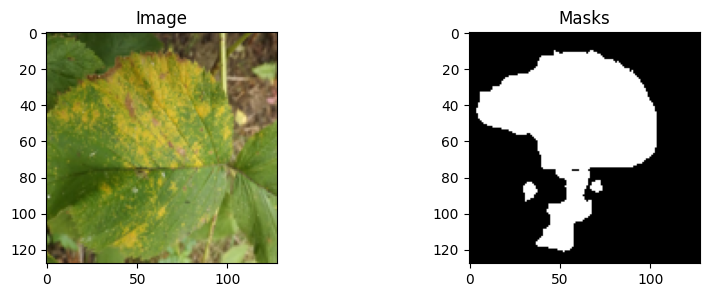

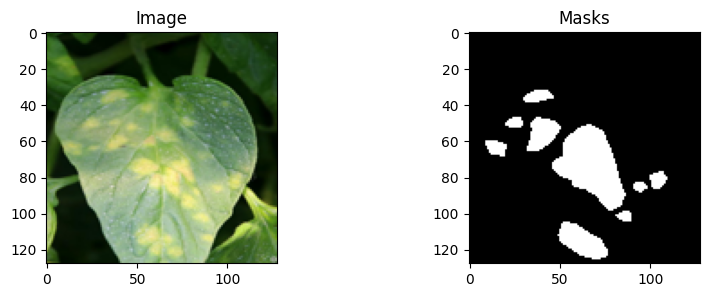

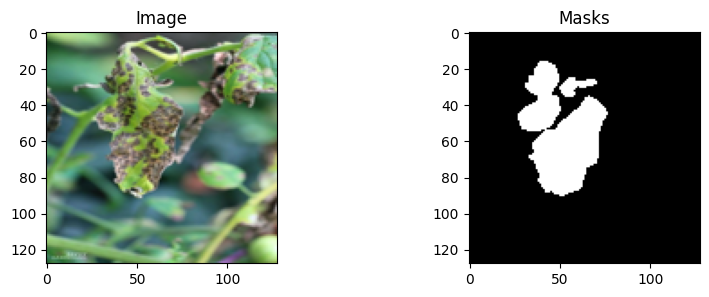

In [3]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Directorios del dataset aumentado
train_image_dir = "/kaggle/input/segmentation-dataset/data/data/images"
train_mask_dir  = "/kaggle/input/segmentation-dataset/data/data/masks"
image_files = [f for f in os.listdir(train_image_dir) if f.endswith(".jpg")]

X_train = np.zeros((len(image_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(image_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

for i, file_name in enumerate(tqdm(image_files)):
    img_path = os.path.join(train_image_dir, file_name)
    mask_name = os.path.splitext(file_name)[0] + ".png"  # reemplazar .jpg → .png
    mask_path = os.path.join(train_mask_dir, mask_name)

    if not os.path.exists(mask_path):
        print(f"⚠️ There is no mask: {mask_name}")
        continue

    img = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT))
    mask = Image.open(mask_path).convert("L").resize((IMG_WIDTH, IMG_HEIGHT))

    mask_array = np.array(mask)

    if np.max(mask_array) == 0:
        print(f"⚠️ Empty mask: {mask_name}")

    X_train[i] = np.array(img)
    Y_train[i] = np.expand_dims(mask_array > 10, axis=-1) # binarización

print("✅ Datos cargados:")
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("Maximum value in X_train:", np.max(X_train))
print("Unique values in Y_train:", np.unique(Y_train))

# Mostrar algunas imágenes y máscaras
for i in range(3):
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(X_train[i])
    plt.title("Image")
    plt.subplot(1, 2, 2)
    plt.imshow(Y_train[i].squeeze(), cmap="gray")
    plt.title("Masks")
    plt.show()

In [4]:
def build_backbone(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet', include_top=False, input_shape=input_shape
    )

    layer_names = [
        "conv2_block3_out",  # 1/4 resolution
        "conv3_block4_out",  # 1/8
        "conv4_block6_out",  # 1/16
    ]
    layers_output = [base_model.get_layer(name).output for name in layer_names]
    backbone = tf.keras.Model(inputs=base_model.input, outputs=layers_output)
    backbone.trainable = False  # puedes cambiarlo si deseas fine-tuning
    return backbone

In [5]:
def ASPP(x):
    dims = x.shape
    y1 = layers.Conv2D(256, 1, padding="same", activation="relu")(x)
    y2 = layers.Conv2D(256, 3, dilation_rate=6, padding="same", activation="relu")(x)
    y3 = layers.Conv2D(256, 3, dilation_rate=12, padding="same", activation="relu")(x)
    y4 = layers.Conv2D(256, 3, dilation_rate=18, padding="same", activation="relu")(x)
    y5 = layers.GlobalAveragePooling2D()(x)
    y5 = layers.Reshape((1, 1, y5.shape[1]))(y5)
    y5 = layers.Conv2D(256, 1, padding="same", activation="relu")(y5)
    y5 = layers.UpSampling2D(size=(dims[1], dims[2]), interpolation="bilinear")(y5)
    
    y = layers.Concatenate()([y1, y2, y3, y4, y5])
    return layers.Conv2D(256, 1, padding="same", activation="relu")(y)

def DeepLabV3Plus(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_classes=1):
    inputs = layers.Input(shape=input_shape)
    backbone = build_backbone(input_shape)
    low_level_feat, mid_feat, high_feat = backbone(inputs)

    x = ASPP(high_feat)
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    low = layers.Conv2D(48, 1, padding="same", activation="relu")(low_level_feat)
    x = layers.Concatenate()([x, low])
    
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    outputs = layers.Conv2D(num_classes, 1, activation="sigmoid")(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [6]:
model = DeepLabV3Plus()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=40,
    batch_size=8
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 32, 32,   │  8,589,184 │ input_layer[0][0] │
│ (Functional)        │ 256), (None, 16,  │            │                   │
│                     │ 16, 512), (None,  │            │                   │
│                     │ 8, 8, 1024)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ functional[0][2]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1,      │          0 │ global_average_p… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 1, 1, 256) │    262,400 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 8, 8, 256) │    262,400 │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 256) │  2,359,552 │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 256) │  2,359,552 │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 256) │  2,359,552 │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 8, 8, 256) │          0 │ conv2d_4[0][0]    │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8,      │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 1280)             │            │ conv2d_1[0][0],   │
│                     │                   │            │ conv2d_2[0][0],   │
│                     │                   │            │ conv2d_3[0][0],   │
│                     │                   │            │ up_sampling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 256) │    327,936 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     12,336 │ functional[0][0]  │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 304)              │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    700,672 │ concatenate_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                 

 Total params: 17,823,921 (67.99 MB)

 Trainable params: 9,234,737 (35.23 MB)

 Non-trainable params: 8,589,184 (32.77 MB)

Epoch 1/40


I0000 00:00:1759763634.769151      75 service.cc:148] XLA service 0x7da4980031a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759763634.769749      75 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759763636.378191      75 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/59 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8026 - loss: 1.8334  

I0000 00:00:1759763644.467896      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


59/59 ━━━━━━━━━━━━━━━━━━━━ 38s 297ms/step - accuracy: 0.8149 - loss: 0.8211 - val_accuracy: 0.8848 - val_loss: 0.2835
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8765 - loss: 0.2934 - val_accuracy: 0.8883 - val_loss: 0.2608
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8850 - loss: 0.2641 - val_accuracy: 0.8985 - val_loss: 0.2366
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8943 - loss: 0.2439 - val_accuracy: 0.9011 - val_loss: 0.2362
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9121 - loss: 0.2041 - val_accuracy: 0.9011 - val_loss: 0.2301
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9032 - loss: 0.2193 - val_accuracy: 0.9043 - val_loss: 0.2282
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9225 - loss: 0.1826 - val_accuracy: 0.9086 - val_loss: 0.2232
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9265 - loss: 0.1734 - val_accuracy: 0.9061 - val_loss: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


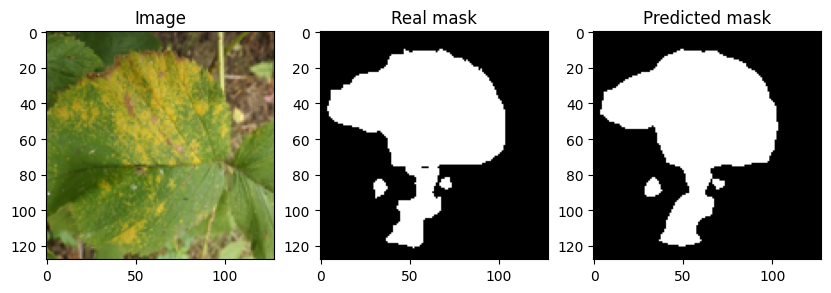

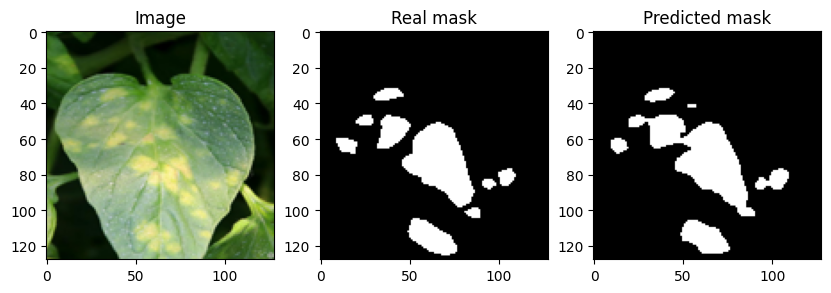

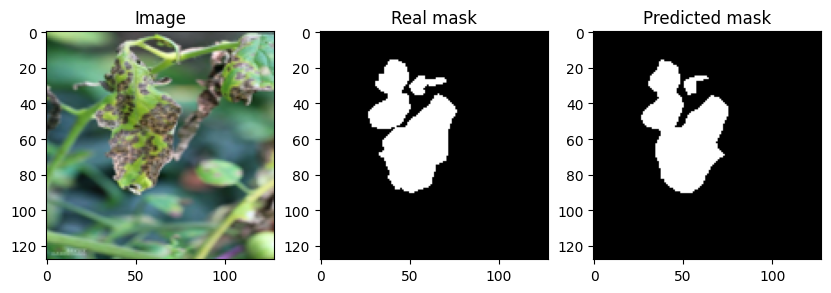

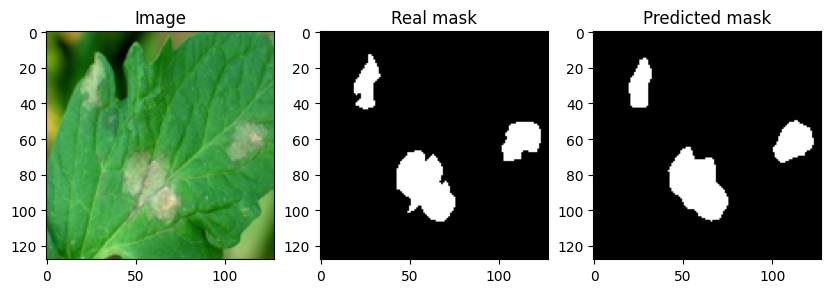

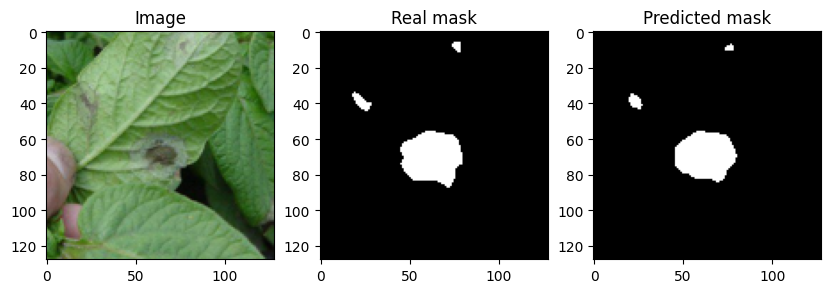

In [7]:
preds = model.predict(X_train[:5])
for i in range(5):
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(X_train[i])
    plt.title("Image")
    plt.subplot(1,3,2)
    plt.imshow(Y_train[i].squeeze(), cmap="gray")
    plt.title("Real mask")
    plt.subplot(1,3,3)
    plt.imshow(preds[i].squeeze() > 0.5, cmap="gray")
    plt.title("Predicted mask")
    plt.show()

In [8]:
# El objeto history ya contiene el historial de entrenamiento
train_acc = history.history['accuracy'][-1]        # Última precisión de entrenamiento
val_acc = history.history['val_accuracy'][-1]      # Última precisión de validación

# Un valor que almacenaste para precisión final en tu bloque 9
unetacc = train_acc  

print(f"Precisión final training accuracy: {train_acc:.4f}")
print(f"Precisión final validation accuracy: {val_acc:.4f}")

Precisión final training accuracy: 0.9751
Precisión final validation accuracy: 0.9185


In [10]:
model.save('Leaf_segmentation.h5')
print ("model saved")

model saved


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


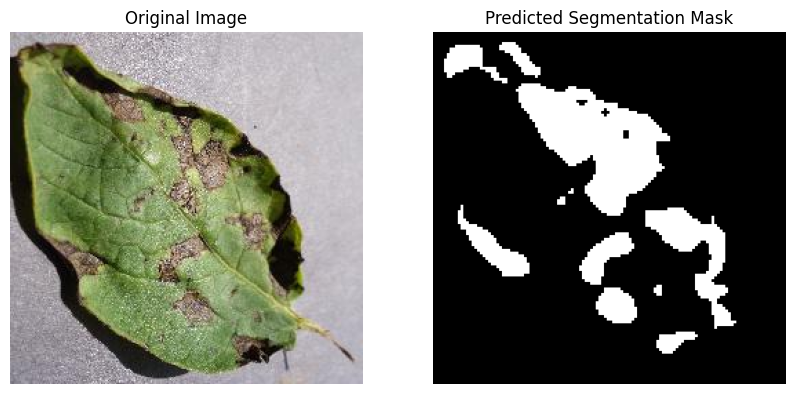

In [19]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load trained model
model = load_model('Leaf_segmentation.h5')

# Load image
image_path = "/kaggle/input/plantdisease/PlantVillage/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG"   # change to your image path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize to training size (128x128)
img_resized = cv2.resize(image, (128, 128))

# ⚠️ Do NOT divide by 255 — you trained on raw 0–255 pixels
img_input = np.expand_dims(img_resized, axis=0)

# Predict mask
pred_mask = model.predict(img_input)[0]

# Convert to binary mask
pred_mask = (pred_mask > 0.5).astype(np.uint8)

# Resize mask to original image size
pred_mask = cv2.resize(pred_mask, (image.shape[1], image.shape[0]))

# Show results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Predicted Segmentation Mask")
plt.imshow(pred_mask, cmap='gray')
plt.axis("off")

plt.show()
